In [6]:
! pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 41.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 87.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [8]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


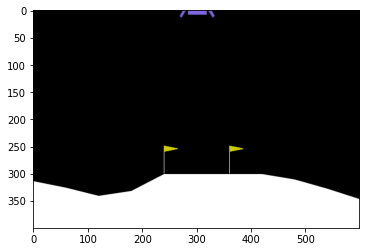

In [7]:
env = gym.make('LunarLander-v2')
env.reset()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(200):
  env.render(mode='rgb_array')
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  if done:
    env.reset()

env.close()

In [11]:
class ActorNet(nn.Module):
  def __init__(self, state_size, action_size, hidden_size):
    super(ActorNet, self).__init__()
    self.dense_layer_1 = nn.Linear(state_size, hidden_size)
    self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
    self.output = nn.Linear(hidden_size, action_size)

  def forward(self, x):
    x = torch.clamp(x, -1.1, 1.1)
    x = F.relu(self.dense_layer_1(x))
    x = F.relu(self.dense_layer_2(x))
    return F.softmax(self.output(x), dim=-1) # -1 to take softmax of last dimension

class ValueFunctionNet(nn.Module):
  def __init__(self, state_size, hidden_size):
    super(ValueFunctionNet, self).__init__()
    self.dense_layer_1 = nn.Linear(state_size, hidden_size)
    self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
    self.output = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = torch.clamp(x, -1.1, 1.1)
    x = F.relu(self.dense_layer_1(x))
    x = F.relu(self.dense_layer_2(x))
    return self.output(x)

In [9]:
class PGAgent():
  def __init__(self, state_size, action_size, hidden_size, actor_lr, vf_lr, discount):
    self.action_size = action_size
    self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
    self.vf_net = ValueFunctionNet(state_size, hidden_size).to(device)
    self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=actor_lr)
    self.vf_optimizer = optim.Adam(self.vf_net.parameters(), lr=vf_lr)
    self.discount = discount

  def select_action(self, state):
    # get action probs then randomly sample from the probabilities
    with torch.no_grad():
      input_state = torch.FloatTensor(state).to(device)
      action_probs = self.actor_net(input_state)
      # detach and turn to numpy to use with np.random.choice()
      action_probs = action_probs.detach().cpu().numpy()
      action = np.random.choice(np.arange(self.action_size), p=action_probs)
    return action

  def train(self, state_list, action_list, reward_list):
    # turn rewards into return
    trajectory_len = len(reward_list)
    return_array = np.zeros((trajectory_len,))
    g_return = 0.
    for i in range(trajectory_len-1, -1, -1):
      g_return = reward_list[i] + self.discount * g_return
      return_array[i] = g_return

    # create tensors
    state_t = torch.FloatTensor(state_list).to(device)
    action_t = torch.LongTensor(action_list).to(device).view(-1, 1)
    return_t = torch.FloatTensor(return_array).to(device).view(-1, 1)

    # get value function estimates
    vf_t = self.vf_net(state_t).to(device)
    with torch.no_grad():
      advantage_t = return_t - vf_t

    # calculate actor loss
    selected_action_prob = self.actor_net(state_t).gather(1, action_t)
    # REINFORCE loss:
    # actor_loss = torch.mean(-torch.log(selected_action_prob) * return_t)
    # REINFORCE Baseline loss
    actor_loss = torch.mean(-torch.log(selected_action_prob) * advantage_t)
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

    # calculate vf loss
    loss_fn = nn.MSELoss()
    vf_loss = loss_fn(vf_t, return_t)
    self.vf_optimizer.zero_grad()
    vf_loss.backward()
    self.vf_optimizer.step()

    return actor_loss.detach().cpu().numpy(), vf_loss.detach().cpu().numpy()

In [12]:
# initialize environment
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 5000 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
actor_lr = 0.002 # learning rate for actor
value_function_lr = 0.002 # learning rate for value function
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 # scale reward by this amount

# create agent
agent = PGAgent(state_size, action_size, hidden_size, actor_lr, value_function_lr, discount)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [18]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_vf_loss = 0., 0.

for ep in range(episodes):
  state = env.reset()
  state_list, action_list, reward_list = [], [], []

  # stopping condition for training if agent reaches the amount of reward
  if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:], axis=0)[1] > 190:
    print("Stopping at episode {} with average rewards of {} in last {} episodes.".
          format(ep, np.mean(stats_rewards_list[-stats_every:], axis=0)[1], stats_every))
    break

  # train in each episode until episode is done
  while True:
    timesteps += 1
    # env.render()
    # select an action from the agent's policy
    action = agent.select_action(state)

    # enter action into the env
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    episode_length += 1
    # store the agent's trajectory
    state_list.append(state)
    action_list.append(action)
    reward_list.append(reward*reward_scale)

    # end episode early
    if total_reward < -250:
      done = 1
    
    if done:
      actor_loss, vf_loss = agent.train(state_list, action_list, reward_list)
      stats_rewards_list.append((ep, total_reward, episode_length))
      stats_actor_loss += actor_loss
      stats_vf_loss += vf_loss
      total_reward = 0
      episode_length = 0
      if ep % stats_every == 0:
        print('Episode: {}'.format(ep),
              'Timestep: {}'.format(timesteps),
              'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:], axis=0)[1]),
              'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:], axis=0)[2]),
              'Actor Loss: {:.4f}'.format(stats_actor_loss/stats_every),
              'VF Loss: {:.4f}'.format(stats_vf_loss/stats_every))
        stats_actor_loss, stats_vf_loss = 0., 0.
      break
    
    state = next_state

Episode: 0 Timestep: 72 Total reward: -303.0 Episode length: 72.0 Actor Loss: -0.0285 VF Loss: 0.0197
Episode: 10 Timestep: 1084 Total reward: -234.2 Episode length: 101.2 Actor Loss: 0.2117 VF Loss: 0.4652
Episode: 20 Timestep: 2100 Total reward: -210.7 Episode length: 101.6 Actor Loss: -0.1830 VF Loss: 0.3002
Episode: 30 Timestep: 3047 Total reward: -213.3 Episode length: 94.7 Actor Loss: -0.0892 VF Loss: 0.2946
Episode: 40 Timestep: 3850 Total reward: -226.8 Episode length: 80.3 Actor Loss: 0.0241 VF Loss: 0.3412
Episode: 50 Timestep: 4763 Total reward: -148.1 Episode length: 91.3 Actor Loss: 0.2267 VF Loss: 0.5626
Episode: 60 Timestep: 5666 Total reward: -172.6 Episode length: 90.3 Actor Loss: -0.3117 VF Loss: 0.1995
Episode: 70 Timestep: 6747 Total reward: -182.3 Episode length: 108.1 Actor Loss: -0.1174 VF Loss: 0.3335
Episode: 80 Timestep: 7939 Total reward: -127.0 Episode length: 119.2 Actor Loss: 0.3329 VF Loss: 0.4986
Episode: 90 Timestep: 9110 Total reward: -112.4 Episode le

Text(0, 0.5, 'Episode Reward')

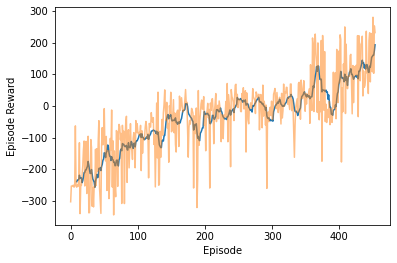

In [19]:
# plot stats
def get_runing_stat(stat, stat_len):
  cum_sum = np.cumsum(np.insert(stat, 0, 0))
  return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_runing_stat(r, 10)
cum_l = get_runing_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

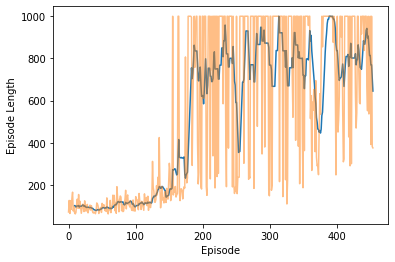

In [20]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')